In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [13]:
# read data
data = pd.read_csv("demo_dataset/feature_0216.csv")

# data info
print(data.info())

# data info (head)
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   color_code      2223 non-null   object
 1   unique_id       2223 non-null   object
 2   black_box       2220 non-null   object
 3   red_circle      2223 non-null   object
 4   green_triangle  2223 non-null   object
 5   blue_pentagon   2208 non-null   object
 6   real_rgb        2223 non-null   object
dtypes: object(7)
memory usage: 121.7+ KB
None
  color_code         unique_id        black_box       red_circle  \
0    7001_21         rotate_35  (190, 175, 154)    (126, 23, 26)   
1    8002_9c            hue_11  (251, 194, 183)  (248, 129, 131)   
2    6004_1A  gaussian_blur_23  (203, 204, 190)    (151, 38, 34)   
3    2002_4B  gaussian_blur_68  (198, 156, 144)    (131, 25, 23)   
4    1004_4C           gamma_3  (226, 221, 252)  (222, 159, 203)   

    green_triangle    blue_pentagon       

In [14]:
data = data.rename(columns={
    "color_code": "ColorCode",
    "unique_id": "UniqueID",
    "black_box": "Cp",
    "red_circle": "Rp",
    "green_triangle": "Gp",
    "blue_pentagon": "Bp",
    "real_rgb": "Cs"
})

data["Rs"] = "(255, 0, 0)"
data["Gs"] = "(0, 255, 0)"
data["Bs"] = "(0, 0, 255)"

# Rp, Gp, Bp, Cp: The color in photo, with the influence of light conditions
# Rs, Gs, Bs, Cs: The real color, it is standard value

print(data.info())

data = data.dropna() # delete NA/none row


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ColorCode  2223 non-null   object
 1   UniqueID   2223 non-null   object
 2   Cp         2220 non-null   object
 3   Rp         2223 non-null   object
 4   Gp         2223 non-null   object
 5   Bp         2208 non-null   object
 6   Cs         2223 non-null   object
 7   Rs         2223 non-null   object
 8   Gs         2223 non-null   object
 9   Bs         2223 non-null   object
dtypes: object(10)
memory usage: 173.8+ KB
None


In [15]:
# 方法二：放差值进去：

import ast
import pandas as pd

# 假设在此之前，你的 `data` 已经具有如下列（字符串类型）：
# ["ColorCode", "UniqueID", "Cp", "Rp", "Gp", "Bp", "Cs", "Rs", "Gs", "Bs"]
# 并且你已经执行了 data.dropna() 等步骤。

# 1. 定义一个函数，将字符串 "(R, G, B)" 解析成 (R_int, G_int, B_int)
def parse_rgb(rgb_string):
    return ast.literal_eval(rgb_string)  # Convert string to (R, G, B) tuple

# 2. 将拍摄值 (Rp, Gp, Bp, Cp) 和目标值 (Cs) 都展开到单独的 R/G/B 列。
#    注：此时 Rs/Gs/Bs 也是字符串，但它们在每一行都是一样的固定值，
#    我们只拿它们来“记一下”标准色是多少即可。
for col in ["Rp", "Gp", "Bp", "Cp"]:
    data[[f"{col}_R", f"{col}_G", f"{col}_B"]] = data[col].apply(parse_rgb).apply(pd.Series)

# 解析目标列 Cs
data[["Cs_R", "Cs_G", "Cs_B"]] = data["Cs"].apply(parse_rgb).apply(pd.Series)

# 3. 构造“参考色拍摄值 - 标准色”的差值
#    - 红色参考物 (Rp) 相对于 (255, 0, 0)
data["Delta_RR_red"] = data["Rp_R"] - 255
data["Delta_RG_red"] = data["Rp_G"] - 0
data["Delta_RB_red"] = data["Rp_B"] - 0

#    - 绿色参考物 (Gp) 相对于 (0, 255, 0)
data["Delta_RR_green"] = data["Gp_R"] - 0
data["Delta_RG_green"] = data["Gp_G"] - 255
data["Delta_RB_green"] = data["Gp_B"] - 0

#    - 蓝色参考物 (Bp) 相对于 (0, 0, 255)
data["Delta_RR_blue"] = data["Bp_R"] - 0
data["Delta_RG_blue"] = data["Bp_G"] - 0
data["Delta_RB_blue"] = data["Bp_B"] - 255

# 4. 最终的特征矩阵 X
#    - 包含：参考色差值(9列) + 目标物拍摄值(3列)
X = data[
    [
        "Delta_RR_red", "Delta_RG_red", "Delta_RB_red",
        "Delta_RR_green", "Delta_RG_green", "Delta_RB_green",
        "Delta_RR_blue", "Delta_RG_blue", "Delta_RB_blue",
        "Cp_R", "Cp_G", "Cp_B",
    ]
]

# 5. 目标变量 y (三个通道：Cs_R, Cs_G, Cs_B)
y = data[["Cs_R", "Cs_G", "Cs_B"]]

# 6. 你不再需要 Rp/Gp/Bp/Cp/Cs 等原始字符串列时，可自由选择是否 drop
# data = data.drop(columns=["Rp", "Gp", "Bp", "Cp", "Cs", "Rs", "Gs", "Bs"])
# (根据你自己的需求来定)

# 7. 后续就是常规的 train_test_split / RandomForestRegressor.fit(X_train, y_train) 等流程


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# split training and test dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=500, random_state=42) # 100 -> 500
rf_model.fit(X_train, y_train)

# Predict Cs
y_pred = rf_model.predict(X_test)


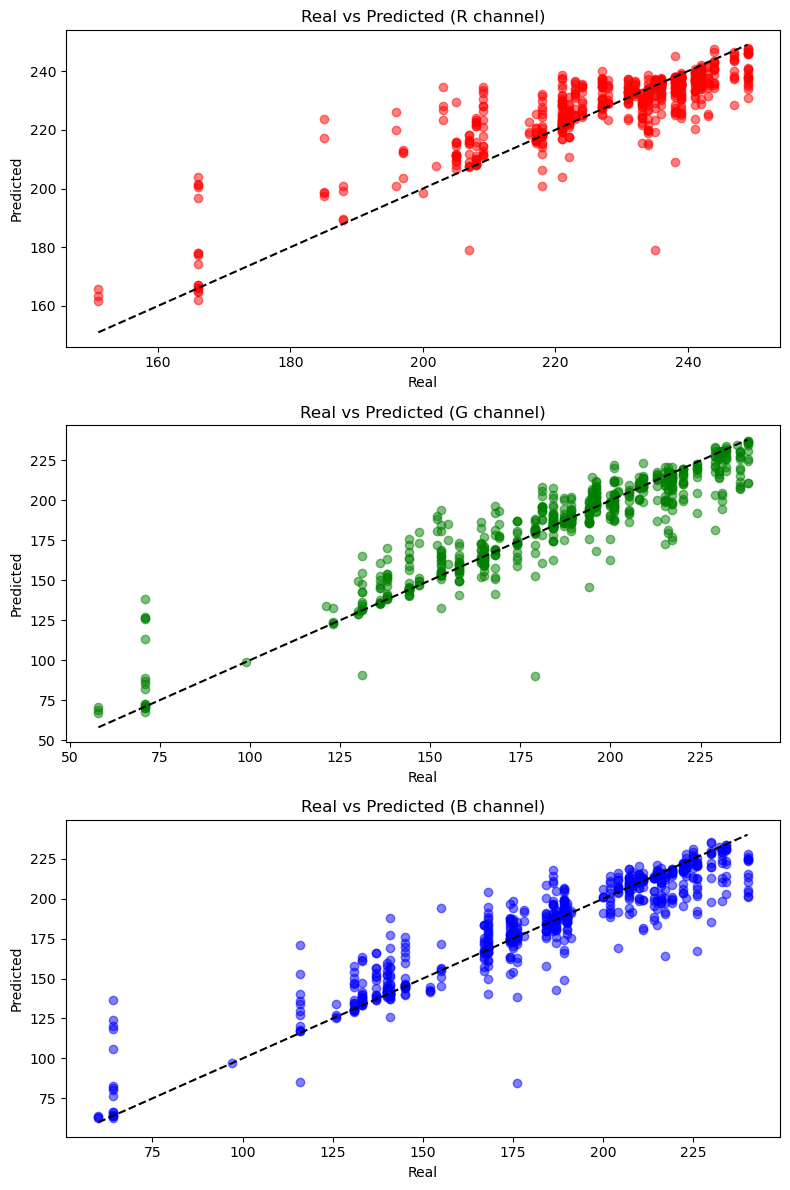

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 12))
colors = ['red', 'green', 'blue']
labels = ['R', 'G', 'B']

for i in range(3):
    axs[i].scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5, color=colors[i])
    axs[i].plot([min(y_test.iloc[:, i]), max(y_test.iloc[:, i])], 
                [min(y_test.iloc[:, i]), max(y_test.iloc[:, i])], linestyle='--', color='black')
    axs[i].set_title(f"Real vs Predicted ({labels[i]} channel)")
    axs[i].set_xlabel("Real")
    axs[i].set_ylabel("Predicted")

plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


R² Score: 0.8225


In [25]:
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")


RMSE: 12.0996


In [26]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")


MAPE: 4.33%


In [27]:
delta_e = np.sqrt(((y_test - y_pred) ** 2).sum(axis=1)).mean()
print(f"Mean Color Difference (ΔE): {delta_e:.2f}")


Mean Color Difference (ΔE): 14.40


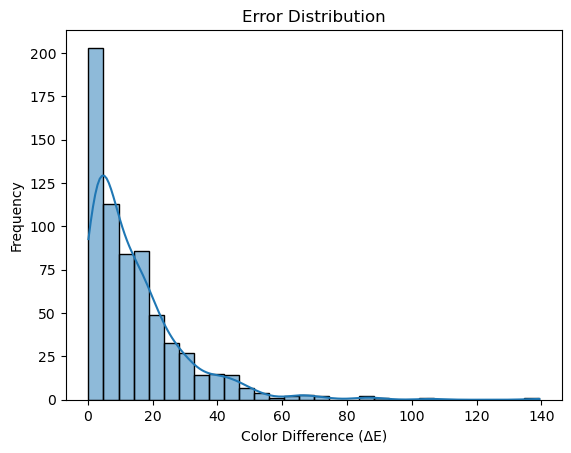

In [28]:
import seaborn as sns

error = np.sqrt(((y_test - y_pred) ** 2).sum(axis=1))  # 计算 ΔE 误差
sns.histplot(error, bins=30, kde=True)
plt.xlabel("Color Difference (ΔE)")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.show()


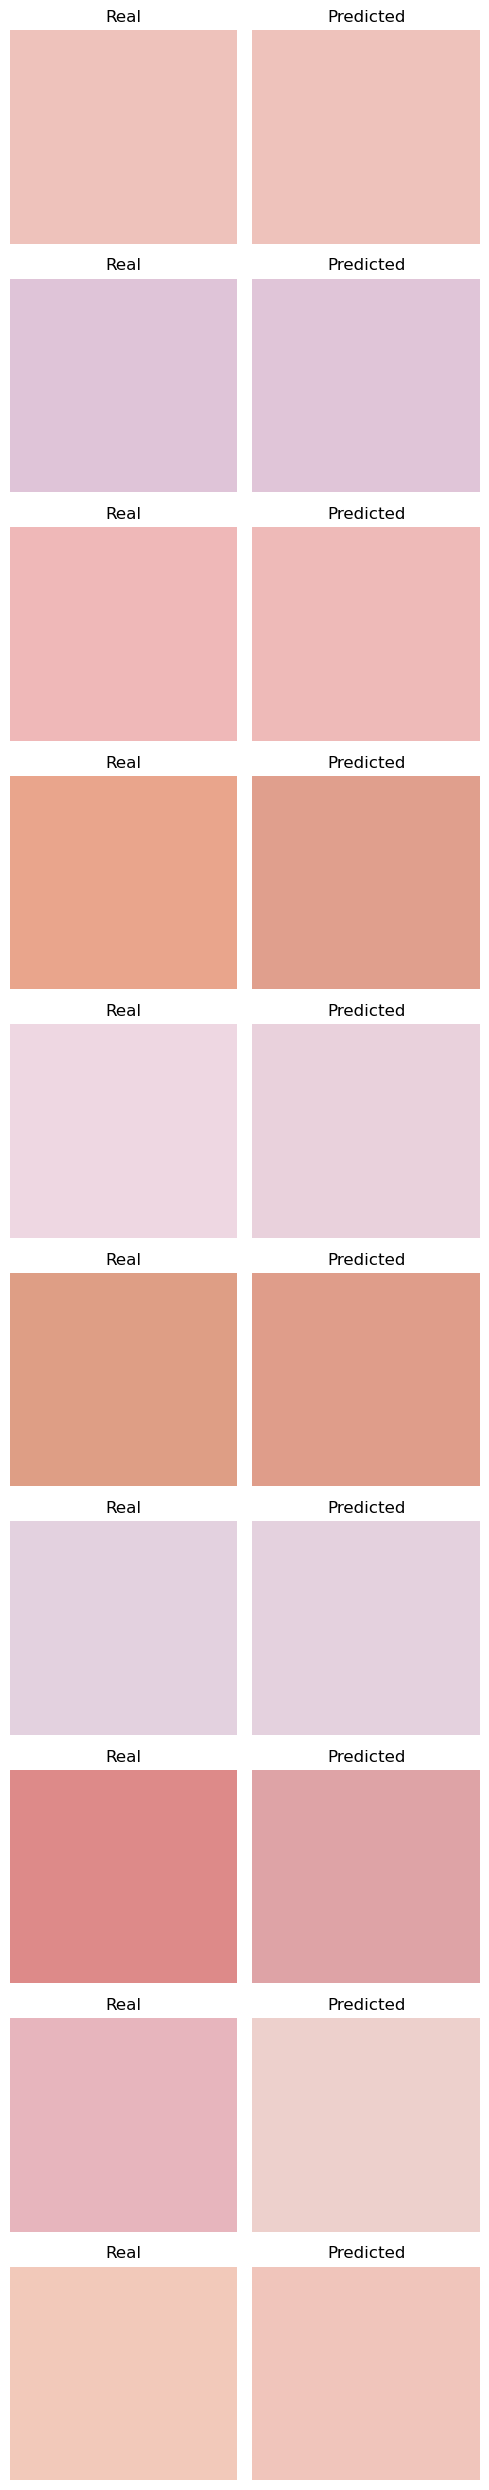

In [29]:
import matplotlib.patches as patches

fig, ax = plt.subplots(10, 2, figsize=(5, 25))  # Display 10 sets of contrasting colors
for i in range(10):
    true_color = tuple(y_test.iloc[i] / 255)  # Normalized to 0-1
    pred_color = tuple(y_pred[i] / 255)

    ax[i, 0].add_patch(patches.Rectangle((0, 0), 1, 1, color=true_color))
    ax[i, 0].set_title("Real")
    ax[i, 0].axis("off")

    ax[i, 1].add_patch(patches.Rectangle((0, 0), 1, 1, color=pred_color))
    ax[i, 1].set_title("Predicted")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [34]:
# -------------------------------------------------
# 新增代码块：计算 Lab 色空间下的 ΔE
# -------------------------------------------------
# 如果你未安装 scikit-image, 请先安装:
# !pip install scikit-image

import numpy as np
from skimage import color

# 1. 将 y_test, y_pred 从 0~255 归一化到 0~1
y_test_norm = y_test.to_numpy() / 255.0  # y_test 是一个 DataFrame, 转成数组更方便
y_pred_norm = y_pred / 255.0            # y_pred 是一个 numpy 数组

# 2. 转换到 Lab 色空间
#   skimage.color.rgb2lab 的输入一般是 (H, W, 3) 形状, 
#   所以我们 reshape 成 (N, 1, 3), 转换后再 reshape 回 (N, 3).
y_test_lab = color.rgb2lab(y_test_norm.reshape(-1, 1, 3)).reshape(-1, 3)
y_pred_lab = color.rgb2lab(y_pred_norm.reshape(-1, 1, 3)).reshape(-1, 3)

# 3. 计算 ΔE = 欧几里得距离
delta_e_lab = np.sqrt(np.sum((y_test_lab - y_pred_lab) ** 2, axis=1))

# 4. 统计指标: 平均值, 中位数等
mean_delta_e_lab = np.mean(delta_e_lab)
median_delta_e_lab = np.median(delta_e_lab)

print(f"Mean ΔE (Lab): {mean_delta_e_lab:.2f}")
print(f"Median ΔE (Lab): {median_delta_e_lab:.2f}")


Mean ΔE (Lab): 5.20
Median ΔE (Lab): 3.96


## ΔE (Lab Color Space) - Color Difference Perception Standard

ΔE (Delta E, Mean Delta E) in the **Lab color space** measures the perceived difference between two colors by the human eye.

| **ΔE Value Range** | **Perceived Difference** |
|--------------------|-------------------------|
| **ΔE < 1** | Nearly imperceptible to the human eye ✅ |
| **1 ≤ ΔE < 3** | Only noticeable upon close observation |
| **3 ≤ ΔE < 6** | Slight but acceptable color difference 🔶 |
| **6 ≤ ΔE < 10** | Noticeable color difference ❌ |
| **ΔE > 10** | Significant color difference, likely incorrect prediction ❌❌ |

A lower ΔE value indicates a better color match, while a higher ΔE suggests a more noticeable difference. 


In [ ]:
# Compare model vs no-model

# -------------------------------------------------
# Baseline: 无模型情况下的预测 (简单平均预测)
# 这一部分的评价方式是ChatGPT提供的，其合理性暂未校验
# 但是可以简单看出RandomForest模型比简单平均效果要好很多
# 在后续的测试中，可以将今天的RandomForest结果作为一个Baseline （Mean ΔE (Lab): 5.20）
# -------------------------------------------------
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from skimage import color

# 1. 计算训练集目标 y_train 的均值 (3 通道)
y_train_mean = y_train.mean(axis=0).values  # DataFrame -> numpy array
print("Mean of Cs (training set):", y_train_mean)

# 2. 对所有测试样本, 预测值都设为该均值
y_pred_baseline = np.tile(y_train_mean, (len(y_test), 1))

# 3. 计算指标 (R², RMSE, MAPE, ΔE-Lab 等)

# -- R² --
r2_baseline = r2_score(y_test, y_pred_baseline)
print(f"Baseline R² Score: {r2_baseline:.4f}")

# -- RMSE --
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline RMSE: {rmse_baseline:.4f}")

# -- MAPE --
mape_baseline = np.mean(np.abs((y_test - y_pred_baseline) / y_test)) * 100
print(f"Baseline MAPE: {mape_baseline:.2f}%")

# -- ΔE (Lab) --
# 先把 y_test / y_pred_baseline 从 [0,255] 归一化到 [0,1]
y_test_norm = y_test.to_numpy() / 255.0
y_pred_baseline_norm = y_pred_baseline / 255.0

# 转到 Lab, 再计算欧几里得距离
y_test_lab = color.rgb2lab(y_test_norm.reshape(-1, 1, 3)).reshape(-1, 3)
y_pred_baseline_lab = color.rgb2lab(y_pred_baseline_norm.reshape(-1, 1, 3)).reshape(-1, 3)

delta_e_baseline = np.sqrt(np.sum((y_test_lab - y_pred_baseline_lab) ** 2, axis=1))
mean_delta_e_baseline = np.mean(delta_e_baseline)
median_delta_e_baseline = np.median(delta_e_baseline)

print(f"Baseline Mean ΔE (Lab): {mean_delta_e_baseline:.2f}")
print(f"Baseline Median ΔE (Lab): {median_delta_e_baseline:.2f}")


Mean of Cs (training set): [228.32080363 186.68114064 183.89112119]
Baseline R² Score: -0.0037
Baseline RMSE: 31.5475
Baseline MAPE: 14.98%
Baseline Mean ΔE (Lab): 14.61
Baseline Median ΔE (Lab): 13.84


In [46]:
# Required imports
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

class PatternDetector:
    def __init__(self):
        """Initialize YOLO models"""
        self.model1 = YOLO("demo_model/model_first.pt")
        self.model2 = YOLO("demo_model/model_second.pt")

    def getPattern(self, image, show_results=True) -> List[Tuple[np.ndarray, str]]:
        """
        Extract patterns from image using YOLO models and return with class labels.
        
        Args:
            image: Input image (numpy array in BGR format)
            show_results: Whether to display detection results
            
        Returns:
            list: List of tuples (pattern_image, class_name), padded to length 4
        """
        # First model detection
        results1 = self.model1(image)
        boxes = results1[0].boxes if results1 else []

        if len(boxes) == 0:
            print("Card Not Recognized")
            return [(None, None)] * 4

        # Crop card area
        box = boxes[0]
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        h, w, _ = image.shape
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)
        image_crop = image[y1:y2, x1:x2]

        # Second model detection
        results2 = self.model2(image_crop)
        boxes = results2[0].boxes if results2 else []

        # Extract patterns with class names
        patterns = []
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            h, w, _ = image_crop.shape
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)
            pattern_crop = image_crop[y1:y2, x1:x2]
            
            # Get class name from model prediction
            class_id = int(box.cls[0])
            class_name = results2[0].names[class_id]
            
            patterns.append((pattern_crop, class_name))

        # Sort patterns by class name if needed
        # Assuming class names are like 'pattern1', 'pattern2', etc.
        patterns.sort(key=lambda x: x[1] if x[1] is not None else '')

        # Pad with None if fewer than 4 patterns detected
        while len(patterns) < 4:
            patterns.append((None, None))
        
        # Truncate if more than 4 patterns detected
        patterns = patterns[:4]

        # Visualize results if requested
        if show_results:
            plt.figure(figsize=(15, 5))
            
            # Show original image
            plt.subplot(1, 6, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')
            plt.axis('off')
            
            # Show cropped card
            plt.subplot(1, 6, 2)
            plt.imshow(cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB))
            plt.title('Cropped Card')
            plt.axis('off')
            
            # Show detected patterns
            for i, (pattern, class_name) in enumerate(patterns, start=1):
                plt.subplot(1, 6, i+2)
                if pattern is not None:
                    plt.imshow(cv2.cvtColor(pattern, cv2.COLOR_BGR2RGB))
                    plt.title(f'{class_name}')
                else:
                    plt.text(0.5, 0.5, 'No Pattern', ha='center', va='center')
                    plt.title('None')
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        
        return patterns

    def getRGB(self, image) -> List[Tuple[Optional[Tuple[int, int, int]], Optional[str]]]:
        """
        Extract RGB values from the center of each pattern using 3x3 grid method.
        
        Args:
            image: Input image (numpy array in BGR format)
            
        Returns:
            list: List of tuples (RGB_value, class_name) or (None, None) for missing patterns
        """
        patterns = self.getPattern(image, show_results=True)
        results = []

        for i, (pattern, class_name) in enumerate(patterns, start=1):
            if pattern is None:
                results.append((None, None))
                continue

            # Convert to RGB
            pattern_rgb = cv2.cvtColor(pattern, cv2.COLOR_BGR2RGB)
            
            # Get center region
            h, w, _ = pattern_rgb.shape
            row_start = h // 3
            row_end = 2 * (h // 3)
            col_start = w // 3
            col_end = 2 * (w // 3)
            
            center_region = pattern_rgb[row_start:row_end, col_start:col_end]
            
            # Calculate average color
            avg_color = tuple(np.mean(center_region, axis=(0, 1)).astype(int))
            results.append((avg_color, class_name))

            # Visualize the center region and its average color
            plt.figure(figsize=(10, 3))
            
            # Original pattern with center region highlighted
            plt.subplot(1, 3, 1)
            plt.imshow(pattern_rgb)
            plt.gca().add_patch(plt.Rectangle((col_start, row_start), 
                                            col_end-col_start, 
                                            row_end-row_start, 
                                            fill=False, 
                                            color='red', 
                                            linewidth=2))
            plt.title(f'{class_name}\nwith Center Region')
            plt.axis('off')
            
            # Center region
            plt.subplot(1, 3, 2)
            plt.imshow(center_region)
            plt.title('Center Region')
            plt.axis('off')
            
            # Average color
            plt.subplot(1, 3, 3)
            color_display = np.full((100, 100, 3), avg_color, dtype=np.uint8)
            plt.imshow(color_display)
            plt.title(f'Average Color\nRGB{avg_color}')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

        return results

# Example usage in notebook:
# # Load and process an image
# detector = PatternDetector()
# image = cv2.imread('demo_image/test_image.png')
# rgb_values = detector.getRGB(image)
# print("RGB values with class names:")
# for rgb, class_name in rgb_values:
#     if rgb is not None:
#         print(f"{class_name}: RGB{rgb}")



0: 640x480 1 color_card, 108.7ms
Speed: 5.8ms preprocess, 108.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x544 1 black_box, 1 red_circle, 1 green_triangle, 1 blue_pentagon, 78.9ms
Speed: 4.9ms preprocess, 78.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


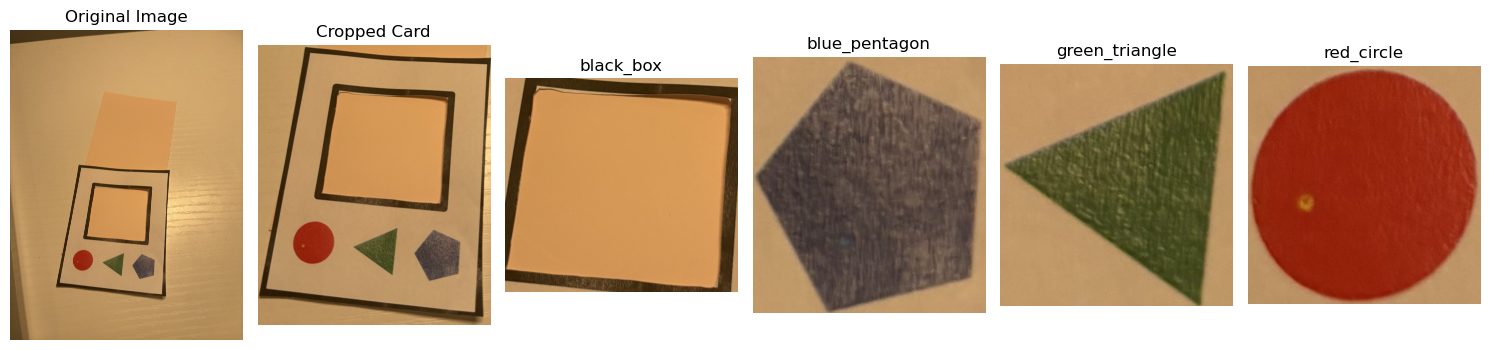

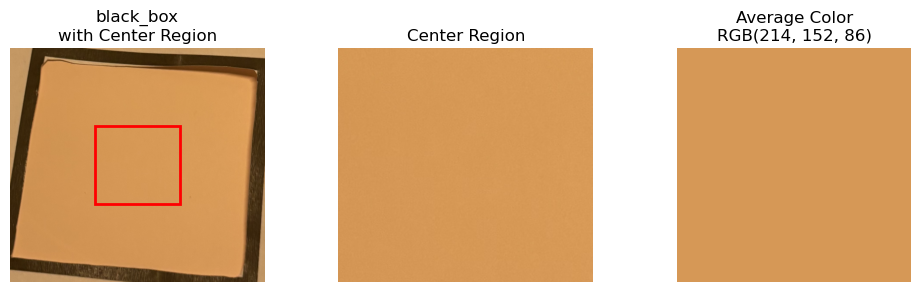

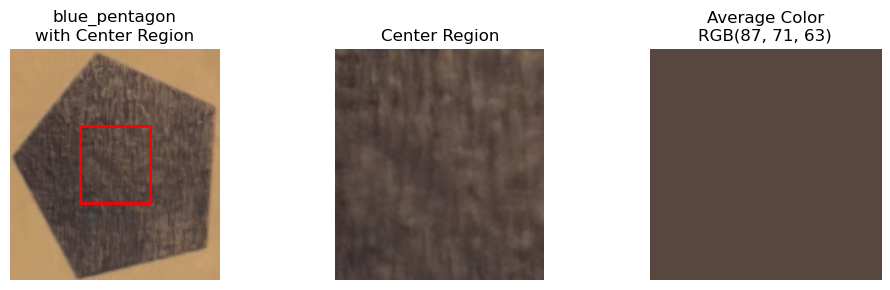

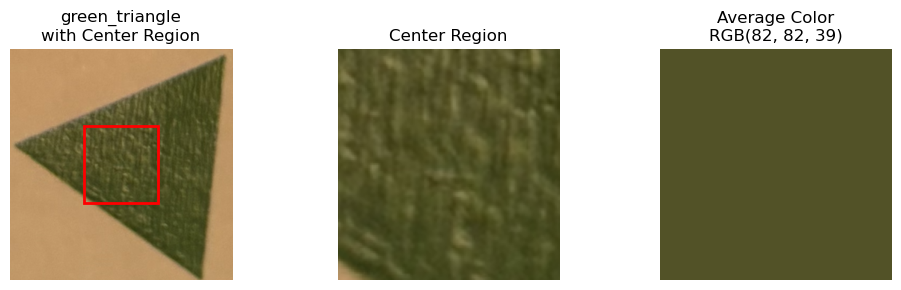

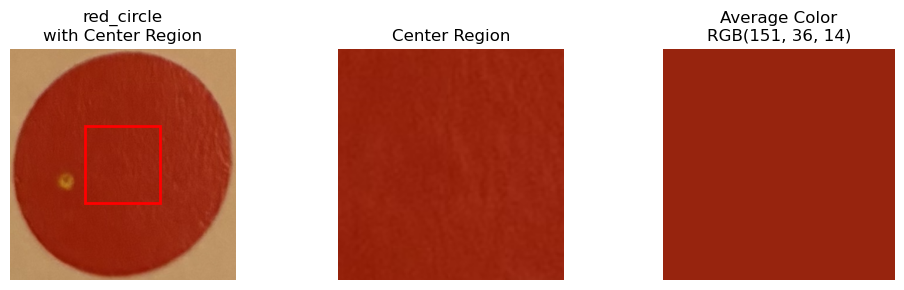

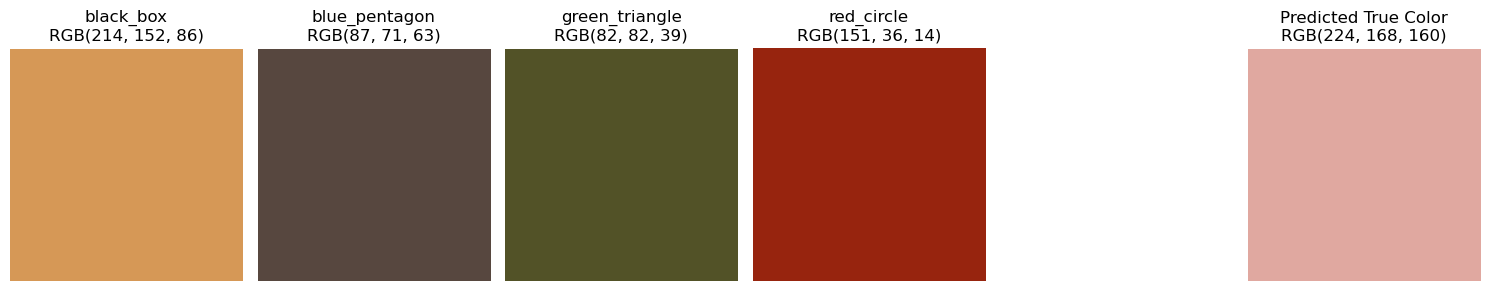


Results:
拍摄到的目标色 (Cp): (214, 152, 86)
模型预测的真实色 (Cs_pred): (224, 168, 160)


In [48]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import ast
import pandas as pd

class ColorPredictionSystem:
    def __init__(self, rf_model: RandomForestRegressor):
        """
        初始化颜色预测系统
        
        Args:
            rf_model: 已训练好的RandomForestRegressor模型实例
        """
        self.pattern_detector = PatternDetector()
        self.rf_model = rf_model
        
        # 定义标准参考色值
        self.reference_colors = {
            'Rs': (255, 0, 0),
            'Gs': (0, 255, 0),
            'Bs': (0, 0, 255)
        }
        
        # 定义形状到颜色参考的映射
        self.pattern_mapping = {
            'red_circle': 'Rp',    # 红色参考物
            'green_triangle': 'Gp', # 绿色参考物
            'blue_pentagon': 'Bp',  # 蓝色参考物
            'black_box': 'Cp'      # 目标物
        }

    def predict_true_color(self, image) -> Tuple[tuple, tuple]:
        """
        预测图像中目标物的真实颜色
        
        Args:
            image: 输入图像（numpy数组）或图像路径
            
        Returns:
            Tuple[tuple, tuple]: (拍摄到的目标色, 预测的真实色)
        """
        # 读取图像（如果输入是路径）
        if isinstance(image, str):
            image = cv2.imread(image)
            if image is None:
                raise ValueError(f"Cannot read image at {image}")

        # 获取各个pattern的RGB值
        pattern_results = self.pattern_detector.getRGB(image)
        
        # 转换为字典
        pattern_dict = {class_name: rgb for rgb, class_name in pattern_results if rgb is not None}
        
        # 检查所需的patterns
        required_patterns = ['red_circle', 'green_triangle', 'blue_pentagon', 'black_box']
        if not all(pattern in pattern_dict for pattern in required_patterns):
            detected_patterns = list(pattern_dict.keys())
            raise ValueError(f"Missing patterns. Required: {required_patterns}, Detected: {detected_patterns}")

        # 提取RGB值
        Rp = pattern_dict['red_circle']     # 红色参考物
        Gp = pattern_dict['green_triangle']  # 绿色参考物
        Bp = pattern_dict['blue_pentagon']   # 蓝色参考物
        Cp = pattern_dict['black_box']       # 目标物

        delta_Rp_R = Rp[0] - 255
        delta_Rp_G = Rp[1] - 0
        delta_Rp_B = Rp[2] - 0

        delta_Gp_R = Gp[0] - 0
        delta_Gp_G = Gp[1] - 255
        delta_Gp_B = Gp[2] - 0

        delta_Bp_R = Gp[0] - 0
        delta_Bp_G = Gp[1] - 0
        delta_Bp_B = Gp[2] - 255



        # 4. 最终的特征矩阵 X
        #    - 包含：参考色差值(9列) + 目标物拍摄值(3列)
        # X = data[
        #     [
        #         "Delta_RR_red", "Delta_RG_red", "Delta_RB_red",
        #         "Delta_RR_green", "Delta_RG_green", "Delta_RB_green",
        #         "Delta_RR_blue", "Delta_RG_blue", "Delta_RB_blue",
        #         "Cp_R", "Cp_G", "Cp_B",
        #     ]
        # ]



        # 构造特征向量
        input_features = [
            delta_Rp_R, delta_Gp_R, delta_Bp_R,
            delta_Rp_G, delta_Gp_G, delta_Bp_G,
            delta_Rp_B, delta_Gp_B, delta_Bp_B,
            Cp[0], Cp[1], Cp[2]
        ]



        # 预测
        # input_features_arr = np.array(input_features).reshape(1, -1)
        # predicted_rgb = tuple(self.rf_model.predict(input_features_arr)[0].astype(int))

        # 定义特征名称 (确保顺序与训练时一致)
        feature_names = [
            "Delta_RR_red", "Delta_RG_red", "Delta_RB_red",
            "Delta_RR_green", "Delta_RG_green", "Delta_RB_green",
            "Delta_RR_blue", "Delta_RG_blue", "Delta_RB_blue",
            "Cp_R", "Cp_G", "Cp_B"
        ]

        # **转换为 DataFrame**
        input_features_df = pd.DataFrame([input_features], columns=feature_names)

        # **进行预测**
        predicted_rgb = tuple(self.rf_model.predict(input_features_df)[0].astype(int))


        # 可视化结果
        self._visualize_results(Cp, predicted_rgb, pattern_dict)

        return Cp, predicted_rgb

    def _visualize_results(self, captured_color: tuple, predicted_color: tuple, pattern_dict: dict = None):
        """
        可视化拍摄色和预测色的对比
        
        Args:
            captured_color: 拍摄到的颜色
            predicted_color: 预测的颜色
            pattern_dict: 所有检测到的pattern颜色（可选）
        """
        if pattern_dict:
            plt.figure(figsize=(15, 4))
            
            # 显示所有参考色和目标色
            for i, (pattern_name, color) in enumerate(pattern_dict.items()):
                plt.subplot(1, 6, i+1)
                color_display = np.full((100, 100, 3), color, dtype=np.uint8)
                plt.imshow(color_display)
                plt.title(f'{pattern_name}\nRGB{color}')
                plt.axis('off')
            
            # 显示预测的真实颜色
            plt.subplot(1, 6, 6)
            color_display = np.full((100, 100, 3), predicted_color, dtype=np.uint8)
            plt.imshow(color_display)
            plt.title(f'Predicted True Color\nRGB{predicted_color}')
            plt.axis('off')
            
        else:
            plt.figure(figsize=(10, 4))
            
            # 显示拍摄到的颜色
            plt.subplot(1, 2, 1)
            color_display = np.full((100, 100, 3), captured_color, dtype=np.uint8)
            plt.imshow(color_display)
            plt.title(f'Captured Color\nRGB{captured_color}')
            plt.axis('off')
            
            # 显示预测的真实颜色
            plt.subplot(1, 2, 2)
            color_display = np.full((100, 100, 3), predicted_color, dtype=np.uint8)
            plt.imshow(color_display)
            plt.title(f'Predicted True Color\nRGB{predicted_color}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# 使用示例：
try:
    # 初始化系统
    system = ColorPredictionSystem(rf_model=rf_model)
    
    # 预测颜色
    captured_color, predicted_color = system.predict_true_color('demo_image/test_image.png')
    
    print("\nResults:")
    print("拍摄到的目标色 (Cp):", captured_color)
    print("模型预测的真实色 (Cs_pred):", predicted_color)
    
except ValueError as e:
    print(f"\n错误: {e}")
except Exception as e:
    print(f"\n发生未预期的错误: {e}")

In [49]:
from skimage.color import rgb2lab, deltaE_cie76

# INPUT TRUE RGB OF TEST COLOR CALIBRATION HERE
true_rgb = (248, 212, 198)


def rgb_to_lab(rgb: tuple) -> np.ndarray:
    """
    将 RGB 颜色转换为 Lab 颜色空间。
    
    Args:
        rgb: 颜色的 (R, G, B) 元组，范围 [0, 255]
    
    Returns:
        np.ndarray: Lab 颜色空间的值
    """
    rgb = np.array(rgb, dtype=np.float32) / 255.0  # 归一化到 [0,1]
    return rgb2lab(rgb.reshape(1, 1, 3)).reshape(3)

# 确保 `true_rgb` 变量已经在内存中定义
true_lab = rgb_to_lab(true_rgb)
captured_lab = rgb_to_lab(captured_color)
predicted_lab = rgb_to_lab(predicted_color)

# 计算 Delta E
delta_e_captured = deltaE_cie76(true_lab, captured_lab)
delta_e_predicted = deltaE_cie76(true_lab, predicted_lab)

print("\n颜色误差分析:")
print(f"拍摄色 (Cp) vs 真实色: ΔE = {delta_e_captured:.2f}")
print(f"预测色 (Cs_pred) vs 真实色: ΔE = {delta_e_predicted:.2f}")



颜色误差分析:
拍摄色 (Cp) vs 真实色: ΔE = 38.07
预测色 (Cs_pred) vs 真实色: ΔE = 16.46
